# Demonstration of added utility depending on time to IVT and MT

In this notebook we examine the relationship between time to treatment and the effect of treatment.

## Plain English summary

Generally we expect a patient's outcome after stroke to depend on how quickly they were treated. The longer between the start of the stroke and the treatment, the less benefit there will be from the treatment.

This document creates a series of graphs to show how the expected benefits vary with time. We first look at the change in added utility, change in average mRS, and change in proportion of patients with an mRS score of two or less. We find how these vary with time to treatment for separate stroke type and treatment combinations.

Then we consider the case where patients receive both IVT and MT. We create a grid of treatment times so we can pick out any combination of time to IVT and time to MT on the grid. On this grid we show the expected change in added utility and in average mRS at any combination of treatment times.

We also combine all of the different combinations of stroke type and treatment type into one big grid of outcomes so that we can see the effect of time to treatment on the whole population.

## Aims

1. To create a line graph of changing outcome with time for each stroke type and treatment type combination.
2. To create a grid of changing outcomes with time for every combination of treatment times for both treatments.

## Method

We set up a series of treatment times running from 0 minutes after onset to the time of no effect. 
+ For IVT, times run from 0 to 6.3 hours (378 minutes) in steps of 10 minutes
+ For MT, times run from 0 to 8 hours (480 minutes) in steps of 10 minutes

__Individual treatment effects__

First, we feed these times into the stroke outcome model and calculate the outcomes for each treatment type separately. We then plot the changing outcome with increasing time.

__Outcome matrix__

We then combine these into a grid of treatment times so that any pair of time to IVT and time to MT can be picked.

All of these treatment time combinations can then be fed into the stroke outcome model to calculate the outcomes after treatment at those times. This builds up a grid of outcomes at any pair of treatment times.

Outcome results are calculated for four patient groups:
1. nLVO receiving IVT
2. LVO receiving IVT only
2. LVO receiving MT only
3. LVO receiving both IVT and MT

And the outcome types shown here are:
+ Added utility compared with no treatment
+ Shift in mean mRS compared with no treatment

We then use the standard [patient population](01b_population.ipynb) to combine the four patient groups into the outcomes after treatment for the whole population.

## Load packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # for axis tick locations

import numpy as np
import pandas as pd
import copy
import os

from stroke_outcome.continuous_outcome import Continuous_outcome

import warnings
warnings.filterwarnings("ignore")

In [2]:
from geography_calc import create_outcome_model_inputs, run_outcome_model, combine_outcomes_treated_ischaemic, combine_outcomes_lvo

In [3]:
dir_output = 'output'
dir_images = 'images'

## Set up model

In [4]:
# Set up outcome model
outcome_model = Continuous_outcome()

## Individual treatment effects

Here we consider the impact, and effect of time to treatment, for three cohorts independently:

1. nLVO receiving IVT
2. LVO receiving IVT only
3. LVO receiving MT (data based on trails where 85% had also received IVT)

Set up shared treatment times:

In [5]:
max_time_to_ivt = 6.3 * 60  # minutes
max_time_to_mt = 8.0 * 60  # minutes

In [6]:
t_step = 1  # minutes
treatment_times_ivt = np.arange(0.0, max_time_to_ivt + t_step, t_step)
treatment_times_mt = np.arange(0.0, max_time_to_mt + t_step, t_step)

Create a dataframe for each cohort:

In [7]:
df_patients_nlvo_ivt = pd.DataFrame()
df_patients_nlvo_ivt['onset_to_needle_mins'] = treatment_times_ivt
df_patients_nlvo_ivt['onset_to_puncture_mins'] = treatment_times_ivt
df_patients_nlvo_ivt['stroke_type_code'] = 1
df_patients_nlvo_ivt['ivt_chosen_bool'] = 1
df_patients_nlvo_ivt['mt_chosen_bool'] = 0
df_patients_nlvo_ivt['label'] = 'nlvo_ivt'

In [8]:
df_patients_lvo_ivt = pd.DataFrame()
df_patients_lvo_ivt['onset_to_needle_mins'] = treatment_times_ivt
df_patients_lvo_ivt['onset_to_puncture_mins'] = treatment_times_ivt
df_patients_lvo_ivt['stroke_type_code'] = 2
df_patients_lvo_ivt['ivt_chosen_bool'] = 1
df_patients_lvo_ivt['mt_chosen_bool'] = 0
df_patients_lvo_ivt['label'] = 'lvo_ivt'

In [9]:
df_patients_lvo_mt = pd.DataFrame()
df_patients_lvo_mt['onset_to_needle_mins'] = treatment_times_mt
df_patients_lvo_mt['onset_to_puncture_mins'] = treatment_times_mt
df_patients_lvo_mt['stroke_type_code'] = 2
df_patients_lvo_mt['ivt_chosen_bool'] = 0
df_patients_lvo_mt['mt_chosen_bool'] = 1
df_patients_lvo_mt['label'] = 'lvo_mt'

Combine the groups into one dataframe:

In [10]:
df_patients = pd.concat(
    (df_patients_nlvo_ivt, df_patients_lvo_ivt, df_patients_lvo_mt),
    ignore_index=True
)

In [11]:
df_patients

onset_to_needle_mins  onset_to_puncture_mins  stroke_type_code  \
0                      0.0                     0.0                 1   
1                      1.0                     1.0                 1   
2                      2.0                     2.0                 1   
3                      3.0                     3.0                 1   
4                      4.0                     4.0                 1   
...                    ...                     ...               ...   
1234                 476.0                   476.0                 2   
1235                 477.0                   477.0                 2   
1236                 478.0                   478.0                 2   
1237                 479.0                   479.0                 2   
1238                 480.0                   480.0                 2   

      ivt_chosen_bool  mt_chosen_bool     label  
0                   1               0  nlvo_ivt  
1                   1               0  nlvo_ivt  
2                   1               0  nlvo_ivt  
3                   1               0  nlvo_ivt  
4                   1               0  nlvo_ivt  
...               ...             ...       ...  
1234                0               1    lvo_mt  
1235                0               1    lvo_mt  
1236                0               1    lvo_mt  
1237                0               1    lvo_mt  
1238                0               1    lvo_mt  

[1239 rows x 6 columns]

Calculate outcomes:

In [12]:
outcome_model.assign_patients_to_trial(df_patients)

In [13]:
# Calculate outcomes:
patient_data_dict, outcomes_by_stroke_type, full_cohort_outcomes = (
    outcome_model.calculate_outcomes())

# Make a copy of the results:
outcomes_by_stroke_type = copy.copy(outcomes_by_stroke_type)
full_cohort_outcomes = copy.copy(full_cohort_outcomes)

Place the relevant results into the starting dataframe:

In [14]:
df_patients['added_utility'] = full_cohort_outcomes['each_patient_utility_shift']
df_patients['mean_mrs'] = full_cohort_outcomes['each_patient_mrs_post_stroke']
df_patients['mrs_less_equal_2'] = full_cohort_outcomes['each_patient_mrs_dist_post_stroke'][:, 2]

In [15]:
df_patients

onset_to_needle_mins  onset_to_puncture_mins  stroke_type_code  \
0                      0.0                     0.0                 1   
1                      1.0                     1.0                 1   
2                      2.0                     2.0                 1   
3                      3.0                     3.0                 1   
4                      4.0                     4.0                 1   
...                    ...                     ...               ...   
1234                 476.0                   476.0                 2   
1235                 477.0                   477.0                 2   
1236                 478.0                   478.0                 2   
1237                 479.0                   479.0                 2   
1238                 480.0                   480.0                 2   

      ivt_chosen_bool  mt_chosen_bool     label  added_utility  mean_mrs  \
0                   1               0  nlvo_ivt       0.158130  1.391000   
1                   1               0  nlvo_ivt       0.157768  1.393199   
2                   1               0  nlvo_ivt       0.157405  1.395401   
3                   1               0  nlvo_ivt       0.157042  1.397603   
4                   1               0  nlvo_ivt       0.156678  1.399808   
...               ...             ...       ...            ...       ...   
1234                0               1    lvo_mt      -0.011106  3.722407   
1235                0               1    lvo_mt      -0.011625  3.725058   
1236                0               1    lvo_mt      -0.012144  3.727707   
1237                0               1    lvo_mt      -0.012662  3.730355   
1238                0               1    lvo_mt      -0.013180  3.733000   

      mrs_less_equal_2  
0             0.752000  
1             0.751600  
2             0.751199  
3             0.750797  
4             0.750396  
...                ...  
1234          0.257007  
1235          0.256505  
1236          0.256002  
1237          0.255501  
1238          0.255000  

[1239 rows x 9 columns]

### Plot outcomes with time

The following function plots the outcomes with time.

In [16]:
from plot_matrix import plot_outcomes_with_time

Setup for plot:

In [17]:
# First three colours of seaborn colourblind:
colours = ['#0072B2', '#009E73', '#D55E00'] 
linestyles = ['-', '--', '-.']

# Set up axis conversion between minutes and hours:
use_hours=True
if use_hours:
    unit_str = 'hours'
    x_times_scale = (1.0 / 60.0)
    xtick_max = (max_time_to_mt+1)/60.0
    major_step = 1
    minor_step = (15.0/60.0) # 15 minutes
else:
    unit_str = 'minutes'
    x_times_scale = 1.0
    xtick_max = max_time_to_mt+1
    major_step = 60.0
    minor_step = 15.0

# Data setup:
# The order of the keys in these dictionaries
# sets up which outcome goes in which axis, and
# which cohort uses each colour and linestyle.
# The value for each key is the prettier label to be displayed.
outcome_labels = {
    'mean_mrs': 'Mean mRS',
    'mrs_less_equal_2': r'Proportion with mRS$\leq$2',
    'added_utility': 'Added utility',
}
cohort_labels = {
    'nlvo_ivt': 'nLVO: IVT',
    'lvo_ivt': 'LVO: IVT',
    'lvo_mt': 'LVO: MT',
}

Plotting:

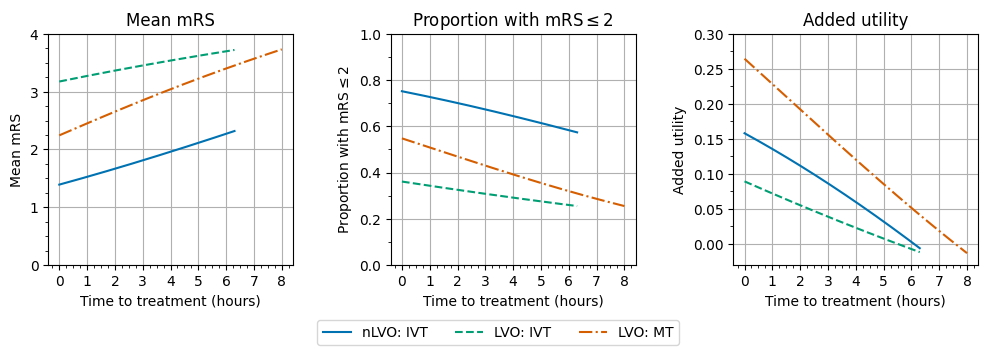

In [18]:
plot_outcomes_with_time(
    df_patients,
    outcome_labels,
    cohort_labels,
    x_times_scale,
    colours,
    linestyles,
    unit_str,
    major_step,
    minor_step,
    savename = './images/time_to_treatment.jpg'
)

Save a copy of the data behind the figure:

In [19]:
df_patients.to_csv(os.path.join(dir_output, 'mean_outcomes_with_time.csv'), index=False)

## Create a grid of treatment times

Use these treatment times:

In [21]:
t_step = 10
time_to_ivt = np.arange(0, max_time_to_ivt + 1, t_step)
time_to_mt = np.arange(0, max_time_to_mt + 1, t_step)

Mesh the two sets of times to get a grid of every combination of times in the two lists:

In [22]:
times_to_ivt_grid, times_to_mt_grid = np.meshgrid(time_to_ivt, time_to_mt)

Flatten the grids back into a column of data and store in this DataFrame:

In [23]:
df_patients_grid = pd.DataFrame()
df_patients_grid['onset_to_needle_mins'] = times_to_ivt_grid.flatten()
df_patients_grid['onset_to_puncture_mins'] = times_to_mt_grid.flatten()

### Set up separate grids for each cohort

Each cohort uses the same grid of treatment times with different stroke and treatment types:

In [24]:
dict_df_patients = create_outcome_model_inputs(df_patients_grid)

In [25]:
for key, df in dict_df_patients.items():
    print(key)
    display(df.head(2))

nlvo_ivt


onset_to_needle_mins  onset_to_puncture_mins  stroke_type_code  \
0                   0.0                     0.0                 1   
1                  10.0                     0.0                 1   

   ivt_chosen_bool  mt_chosen_bool  
0                1               0  
1                1               0

lvo_ivt_only


onset_to_needle_mins  onset_to_puncture_mins  stroke_type_code  \
0                   0.0                     0.0                 2   
1                  10.0                     0.0                 2   

   ivt_chosen_bool  mt_chosen_bool  
0                1               0  
1                1               0

lvo_ivt_mt


onset_to_needle_mins  onset_to_puncture_mins  stroke_type_code  \
0                   0.0                     0.0                 2   
1                  10.0                     0.0                 2   

   ivt_chosen_bool  mt_chosen_bool  
0                1               1  
1                1               1

lvo_mt_only


onset_to_needle_mins  onset_to_puncture_mins  stroke_type_code  \
0                   0.0                     0.0                 2   
1                  10.0                     0.0                 2   

   ivt_chosen_bool  mt_chosen_bool  
0                0               1  
1                0               1

### Calculate outcomes for each cohort

In [26]:
for key, df in dict_df_patients.items():
    dict_df_patients[key] = run_outcome_model(df)

In [27]:
for key, df in dict_df_patients.items():
    print(key)
    display(df.head(2))

nlvo_ivt


onset_to_needle_mins  onset_to_puncture_mins  stroke_type_code  \
0                   0.0                     0.0                 1   
1                  10.0                     0.0                 1   

   ivt_chosen_bool  mt_chosen_bool  added_utility  mean_mrs  mrs_less_equal_2  \
0                1               0       0.158130  1.391000          0.752000   
1                1               0       0.154488  1.413068          0.747977   

   mrs_shift  
0  -0.889000  
1  -0.866932

lvo_ivt_only


onset_to_needle_mins  onset_to_puncture_mins  stroke_type_code  \
0                   0.0                     0.0                 2   
1                  10.0                     0.0                 2   

   ivt_chosen_bool  mt_chosen_bool  added_utility  mean_mrs  mrs_less_equal_2  \
0                1               0       0.089380  3.176000          0.361000   
1                1               0       0.086467  3.192402          0.357948   

   mrs_shift  
0  -0.464000  
1  -0.447598

lvo_ivt_mt


onset_to_needle_mins  onset_to_puncture_mins  stroke_type_code  \
0                   0.0                     0.0                 2   
1                  10.0                     0.0                 2   

   ivt_chosen_bool  mt_chosen_bool  added_utility  mean_mrs  mrs_less_equal_2  \
0                1               1         0.2646     2.244             0.548   
1                1               1         0.2646     2.244             0.548   

   mrs_shift  
0     -1.396  
1     -1.396

lvo_mt_only


onset_to_needle_mins  onset_to_puncture_mins  stroke_type_code  \
0                   0.0                     0.0                 2   
1                  10.0                     0.0                 2   

   ivt_chosen_bool  mt_chosen_bool  added_utility  mean_mrs  mrs_less_equal_2  \
0                0               1         0.2646     2.244             0.548   
1                0               1         0.2646     2.244             0.548   

   mrs_shift  
0     -1.396  
1     -1.396

### Plot outcomes for each cohort

Take the columns of data, reshape them into grids, and display the grids with a colour scale.

Setup for plots:

In [28]:
# Instead of the axes showing the row, column numbers of the grid,
# use this extent to scale the row, column numbers to the times.
# Extra division by 60 for conversion to hours.
grid_extent = np.array([
    min(time_to_ivt) - t_step * 0.5, max(time_to_ivt) + t_step * 0.5,  # x-limits
    min(time_to_mt) - t_step * 0.5, max(time_to_mt) + t_step * 0.5     # y-limits
]) / 60.0

# How many rows and columns of data are there?
grid_shape = (len(time_to_mt), len(time_to_ivt))

# Data setup:
# The order of the keys in these dictionaries
# sets up which outcome goes in which axis, and
# which cohort uses each colour and linestyle.
# The value for each key is the prettier label to be displayed.
outcome_labels = {
    'added_utility': 'Added utility',
    'mrs_shift': 'Mean change in mRS',
}
cohort_labels = {
    'nlvo_ivt': 'nLVO treated with IVT',
    'lvo_ivt_only': 'LVO treated with IVT',
    'lvo_mt_only': 'LVO treated with MT',
    'lvo_ivt_mt': 'LVO treated with IVT and MT',
}

# Data sources:
dfs = {
    'nlvo_ivt': dict_df_patients['nlvo_ivt'],
    'lvo_ivt_only': dict_df_patients['lvo_ivt_only'],
    'lvo_mt_only': dict_df_patients['lvo_mt_only'],
    'lvo_ivt_mt': dict_df_patients['lvo_ivt_mt'],
}

# Colour setup.
cmaps = ['plasma', 'viridis_r']
# Pick out shared colour scale limits:
vlims = {
    'added_utility': [
        min([df['added_utility'].min() for df in dfs.values()]),
        max([df['added_utility'].max() for df in dfs.values()]),
    ],
    'mrs_shift': [
        min([df['mrs_shift'].min() for df in dfs.values()]),
        max([df['mrs_shift'].max() for df in dfs.values()]),
    ],
}
# Shared contour levels:
levels = {
    'added_utility': np.arange(0.00, 0.25 + 0.01, 0.05),
    'mrs_shift': np.arange(-1.2, 0.0 + 0.01, 0.2),
}

Plotting:

In [29]:
from plot_matrix import plot_matrices

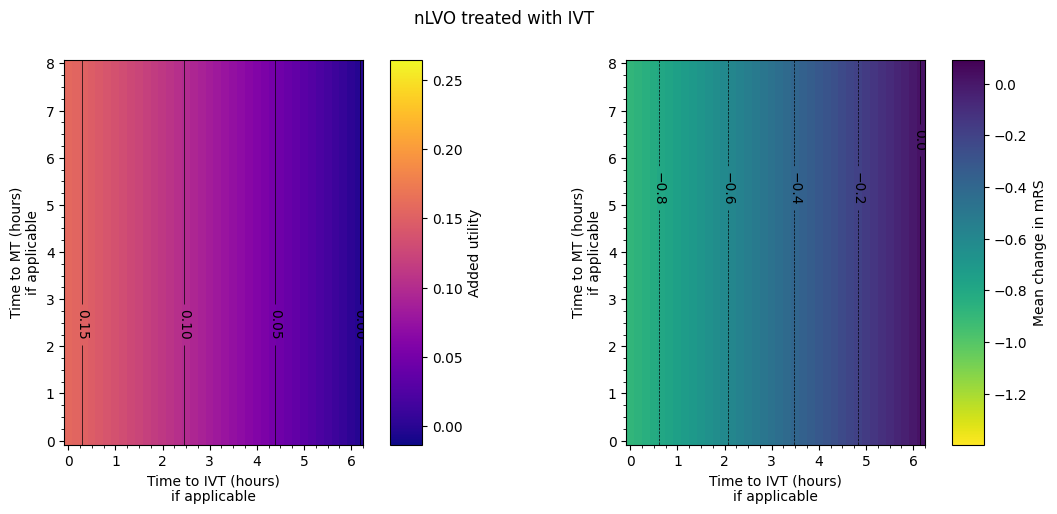

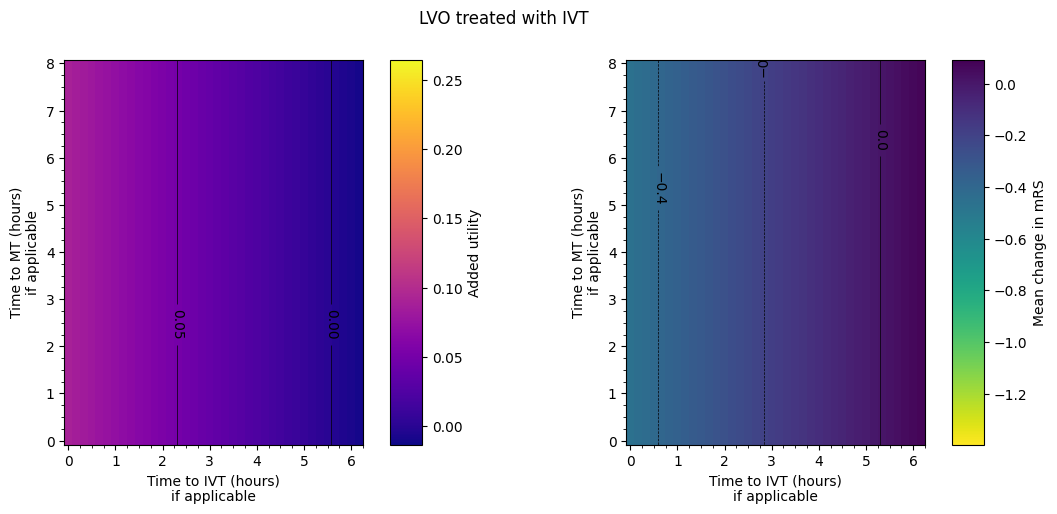

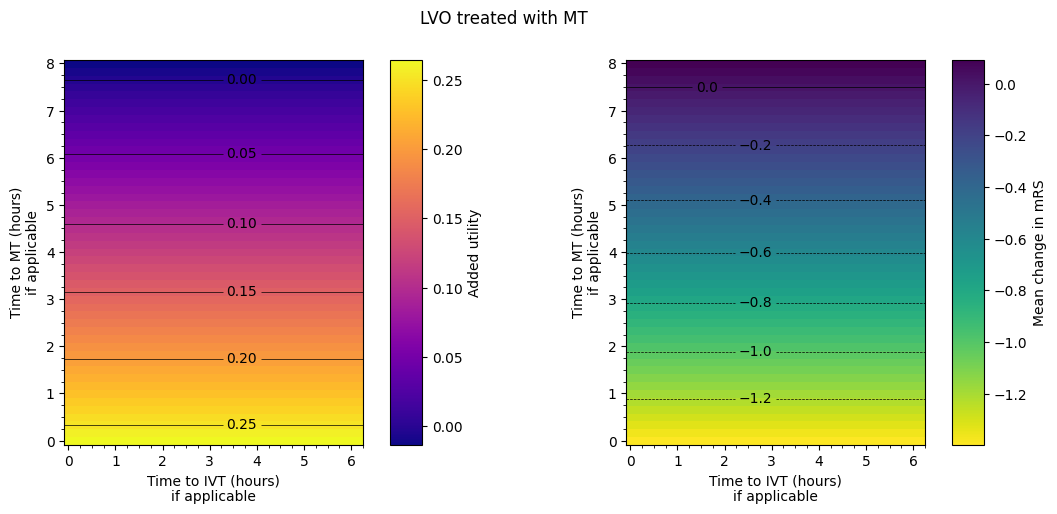

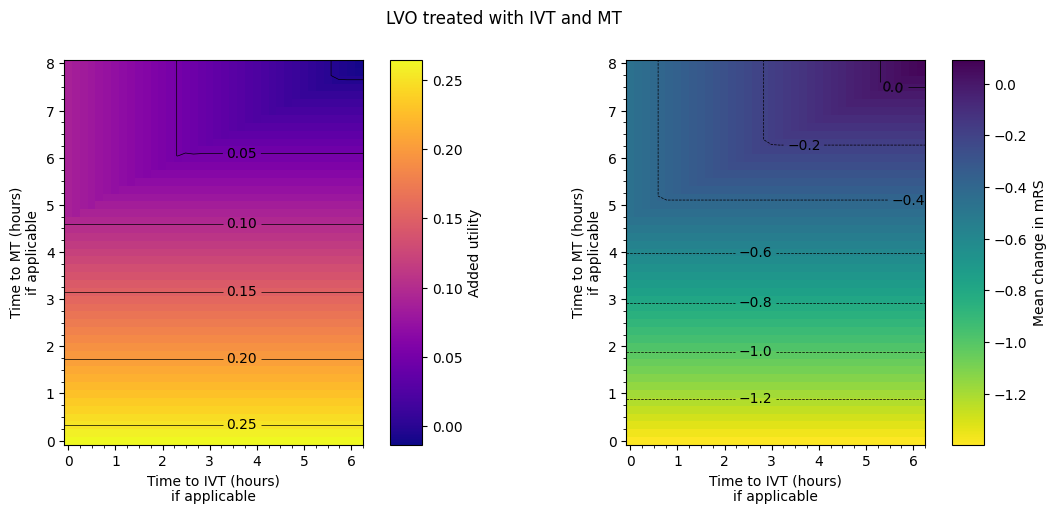

In [30]:
for cohort_name, cohort_label in cohort_labels.items():
    plot_matrices(
        dfs[cohort_name],
        outcome_labels,
        grid_shape,
        grid_extent,
        vlims,
        major_step,
        minor_step,
        levels,
        title=cohort_label,
        cmaps=cmaps,
        savename=os.path.join(dir_images, f'matrix_utility_and_mRS_{cohort_name}.jpg')
    )

The spacing between contours in terms of time isn't necessarily exactly equal for each pair of adjacent contours. From eyeballing these charts, we find:

+ nLVO with IVT:
  + around extra two hours to treatment --> drop in added utility of 0.05.
  + around extra hour and a half to treatment --> worsening of mean mRS of 0.2.
+ LVO with IVT only:
  + around extra three hours to treatment --> drop in added utility of 0.05.
  + around extra two and a quarter hours to treatment --> worsening of mean mRS of 0.2.
+ LVO with MT only:
  + around extra hour and a half to treatment --> drop in added utility of 0.05.
  + around extra hours to treatment --> worsening of mean mRS of 0.2.
+ LVO with IVT only:
  + uses the results from MT only in a certain regime and the results from IVT only outside it. The regime is when MT has been given approximately four and three quarters of an hour plus half the time to IVT. MT = 4.75 + 0.5*IVT.

The following notebook __TO DO LINK ME__ makes more thorough estimates of the changing outcomes with time.

## Combining patient groups

Here we examined the combined effect of IVT and MT on outcomes across nLVO and LVO ischaemic strokes.


In [31]:
patient_proportions = pd.read_csv(
    os.path.join('..', 'england_wales', 'output', 'patient_proportions.csv'),
    index_col=0, header=None).squeeze()

In [32]:
patient_proportions

0
haemorrhagic         0.13600
lvo_no_treatment     0.14648
lvo_ivt_only         0.00840
lvo_ivt_mt           0.08500
lvo_mt_only          0.01500
nlvo_no_treatment    0.50252
nlvo_ivt             0.10660
Name: 1, dtype: float64

### Calculate outcomes for the combined cohorts:

In [33]:
df_lvo = combine_outcomes_lvo(
    dict_df_patients['lvo_ivt_only'],
    dict_df_patients['lvo_ivt_mt'],
    dict_df_patients['lvo_mt_only'],
    patient_proportions,
    outcome_cols=[]
)

In [34]:
df_mixed = combine_outcomes_treated_ischaemic(
    dict_df_patients['nlvo_ivt'],
    dict_df_patients['lvo_ivt_only'],
    dict_df_patients['lvo_ivt_mt'],
    dict_df_patients['lvo_mt_only'],
    patient_proportions,
    outcome_cols=[]
)

In [45]:
dfs['lvo'] = df_lvo
dfs['treated_ischaemic'] = df_mixed

### Plot LVO mix

Plot the LVO mix with the same colour settings as the previous figures:

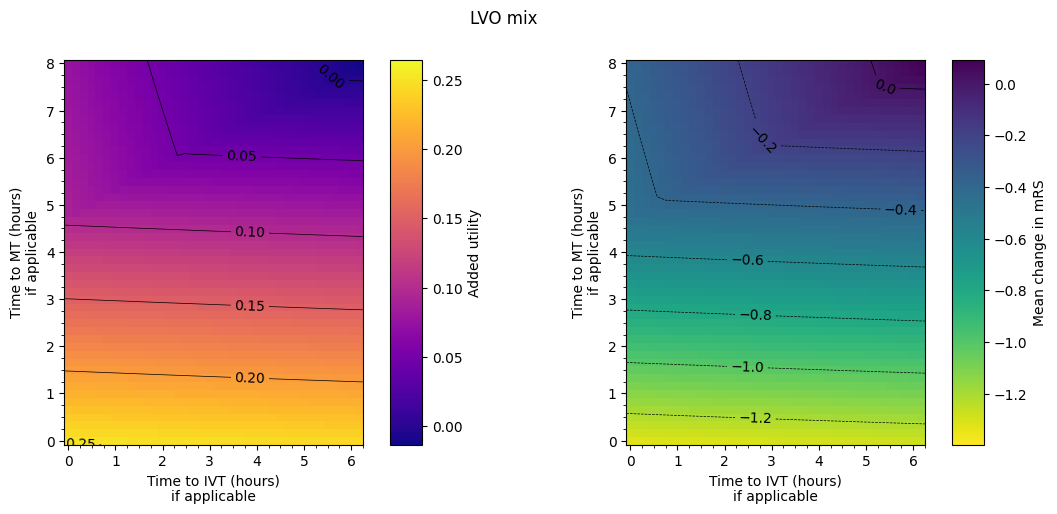

In [35]:
plot_matrices(
    df_lvo,
    outcome_labels,
    grid_shape,
    grid_extent,
    vlims,
    major_step,
    minor_step,
    levels,
    title='LVO mix',
    cmaps=cmaps,
    savename=os.path.join(dir_images, 'matrix_utility_and_mRS_lvo.jpg')
)

### Plot the mixed cohort

Setup for plots:

In [36]:
# Data setup:
# The order of the keys in these dictionaries
# sets up which outcome goes in which axis, and
# which cohort uses each colour and linestyle.
# The value for each key is the prettier label to be displayed.
outcome_labels = {
    'added_utility': 'Mean population added utility',
    'mrs_shift': 'Mean population change in mRS',
}

# Colour setup:
cmaps = ['plasma', 'viridis_r']
# Contour levels:
levels = {
    'added_utility': np.arange(0.0, 0.2 + 0.01, 0.025),
    'mrs_shift': np.arange(-1.0, 0.0 + 0.01, 0.2),
}

# Use default colour limits:
vlims = {
    'added_utility': [None, None],
    'mrs_shift': [None, None],
}

Make the plot:

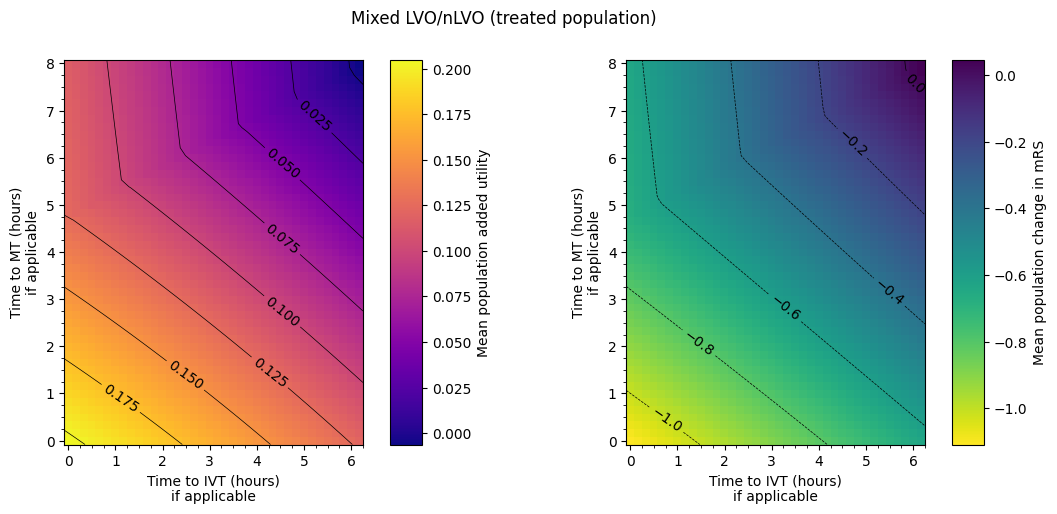

In [37]:
plot_matrices(
    df_mixed,
    outcome_labels,
    grid_shape,
    grid_extent,
    vlims,
    major_step,
    minor_step,
    levels,
    title='Mixed LVO/nLVO (treated population)',
    cmaps=cmaps,
    savename=os.path.join(dir_images, 'matrix_utility_and_mRS_mixed.jpg')
)

Data ranges:

In [38]:
cols = ['added_utility', 'mrs_shift']

df_ranges = pd.DataFrame(
    np.array([[df_mixed[c].min(), df_mixed[c].max()] for c in cols]).T,
    columns=cols,
    index=['Minimum', 'Maximum']
)

df_ranges

added_utility  mrs_shift
Minimum      -0.006181  -1.108209
Maximum       0.204965   0.046879

Save a copy of the data behind these matrices:

In [46]:
for key, df in dfs.items():
    df.to_csv(os.path.join(dir_output, f'outcome_matrix_{key}.csv'), index=False)

Print the names that went into the names of the files we just saved to make it easier to import them all again later:

In [47]:
dfs.keys()

dict_keys(['nlvo_ivt', 'lvo_ivt_only', 'lvo_mt_only', 'lvo_ivt_mt', 'lvo', 'mixed', 'treated_ischaemic'])

## Conclusion

__Individual treatment effects__

![Line graphs of benefit in outcomes with time to treatment for the separate stroke types and treatment types.](./images/time_to_treatment.jpg)

Over time:
+ the mean mRS increases. The average disability score gets worse.
+ the proportion of patients with an mRS score of 2 or less decreases. Fewer patients have a "good" outcome after stroke.
+ the added utility compared with no treatment decreases. The drop in added utility is most drastic (the line is steepest) for MT.

The different patient groups show the same trends although the start and end points and the steepness of each line are different.

The results _look_ quite like straight lines, i.e. the benefits worsen linearly with time, but they are not defined as such and are not actually quite straight. The difference between these benefits with time and straight line fits to them are shown in the following notebook.

__Outcome matrices__

![Grid of outcomes with time to IVT and time to MT for a mix of treated ischaemic patients.](./images/matrix_utility_and_mRS_mixed.jpg)

The final plot of the grids of outcomes for the mixed treated population show that the improvement in outcomes is best when the times to treatment are lower, i.e. the colours on the plot are lighter in the bottom-left corner. The contour lines of constant outcomes show that the same benefit from treatment can be achieved when the time for one treatment is decreased and the time for the other is increased.

A different trend is seen when there is low time to IVT and high time to MT, i.e. in the top-left corner of the grid. Still generally lower treatment times give better outcomes, but the combination of treatment times that give the same benefit are different, i.e. the contours have a different slope. This different trend originates in the LVO-only data. When patients are treated with both IVT and MT, the outcome model checks which treatment would give the better outcomes (the higher added utility) and uses the results from only that treatment. For most cases in the grid, MT gives better outcomes and so the MT results are used. When time to IVT is low and time to MT is high in that top-left corner, IVT gives better outcomes and so the IVT results are used. The diagonal line where the contours bend marks the location of the change from the MT-better regime to the IVT-better regime.

The following notebook digs more into the maths in these matrices to quantify these findings.